## To Vaccinate or Not to Vaccinate: Analysing social media sentiment towards vaccines

Although it may be many months before we see COVID-19 vaccines available on a global scale, it is important to monitor public sentiment towards vaccinations now and especially in the future when COVID-19 vaccines are offered to the public. The anti-vaccination sentiment could pose a serious threat to the global efforts to get COVID-19 under control in the long term.

The objective of this challenge is to develop a machine learning model to assess if a Twitter post related to vaccinations is positive, neutral, or negative. 

The challenge is of an NLP kind.
* NLP (Natural Language Processing): is a machine-learning sub category that entails a wide range of techniques designed to help machines learn from text. 
    * Natural Language Processing is most commonly used in chatbots and search engines; and in tasks such as sentiment analysis and machine-translation(e.g.google-translate).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
import xgboost as xgb

import utils # Custom functions defined in utils.py
import re
import os

import warnings
warnings.filterwarnings('ignore')

/home/quanta/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/quanta/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/quanta/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
train_df = pd.read_csv('./raw_data/Train.csv')
test_df = pd.read_csv('./raw_data/Test.csv')
sub = pd.read_csv('./raw_data/SampleSubmission.csv')

### Tweet exploration

Let's have a glimpse as to what pro-vaccination, neutral and anti-vaccination tweets look like

In [3]:
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [4]:
# Neutral
train_df[train_df['label'] == 0]['safe_text'].values[0]

'Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>'

In [5]:
# Pro-vaccination
train_df[train_df['label'] == 1]['safe_text'].values[0]

"I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day"

In [6]:
# Anti-vaccination
train_df[train_df['label'] == -1]['safe_text'].values[0]

'#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD'

In [7]:
print(train_df.label.value_counts())
# Slicing out the outlier label(0.666667) 
train_df = train_df[train_df['label'].isin([-1, 0, 1])]

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64


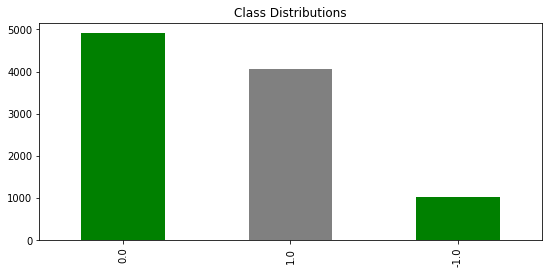

In [8]:
plt.figure(figsize=(9,4))
plt.title('Class Distributions')
train_df.label.value_counts().plot(kind='bar', color=('green', 'gray'))

In [9]:
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


### Text Preprocessing:
* Remove stop words
* Remove symbols.e.g ampasands(&),question_marks(?), exclamation_marks(!)
* Remove html tags from tweets
* Remove urls
* Remove emojis
* Remove single characters (The model will not learn anything useful with them)

In [10]:
#test_df[test_df['safe_text'].isnull() == True]
train_df.dropna(inplace=True) # NAN labeled row
test_df.fillna(value='am ok with it as long as its not dangerous', inplace=True) #null safe_text row (its a random imputation)

In [11]:
# Clean train_df
train_df['safe_text'] = train_df.safe_text.apply(utils.remove_html)
train_df['safe_text'] = train_df.safe_text.apply(utils.remove_URL)
train_df['safe_text'] = train_df.safe_text.apply(utils.clean_text)
train_df['safe_text'] = train_df.safe_text.apply(utils.remove_emoji)

# Clean train_df
test_df['safe_text'] = test_df.safe_text.apply(utils.remove_html)
test_df['safe_text'] = test_df.safe_text.apply(utils.remove_URL)
test_df['safe_text'] = test_df.safe_text.apply(utils.clean_text)
test_df['safe_text'] = test_df.safe_text.apply(utils.remove_emoji)

In [12]:
# split data into documents/features and labels
X = train_df.safe_text
y = train_df.label

### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data a machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with.

In [13]:
# Create train and test vectors
train_vectors, count_vectorizer = utils.count_vectorize(X)

# Map the tokens in the train vectors to the test set. 
# i.e.the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df['safe_text'])

### Building the model

Words contained in each tweet are a good indicator of whether they're about `pro vaccination(1)`, `neutral(0)` or `anti-vaccination(-1)`. The presence of particular word (or set of words) in a tweet might link directly to any of the aforementioned cases.


In [14]:
# train-test split
X_train, X_val, y_train, y_val = train_test_split(train_vectors, y, test_size=0.2, random_state=0)

In [17]:
# Model with Cross-Validation
scores = []
kf = StratifiedKFold(10, shuffle=True, random_state=4242)
for i, (tr, val) in enumerate(kf.split(train_vectors, y)):
    X_tr, y_tr = train_vectors[tr], np.take(y, tr, axis=0)
    X_val, y_val = train_vectors[val], np.take(y, val, axis=0)
    xgb_clf = xgb.XGBClassifier(max_depth=9, n_estimators=200, colsample_bytree=0.9, 
                               objective='multi:softmax', subsample=0.9,
                               nthread=2, learning_rate=0.132, random_state=4242
                              )
    xgb_clf.fit(X_tr, y_tr)
    val_probs = xgb_clf.predict_proba(X_val)
    val_preds = [(pred.argmax()-1) * pred[pred.argmax()] for pred in val_probs]
    score = utils.rmse(y_val, val_preds)
    scores.append(score)
    print(score)
print(f'Mean_RMSE: {np.mean(scores)}')

0.5824003564325554
0.5846399573121605
0.5757161614594681
0.5827628476575691
0.5929664887281194
0.6104290671851648
0.5870898600266632
0.5846725338123866
0.5908842930210719
0.5733562737732312
Mean_RMSE: 0.5864917839408391


## Making predictions

In [18]:
test_probs = xgb_clf.predict_proba(test_vectors)
test_preds = [(pred.argmax()-1) * pred[pred.argmax()] for pred in test_probs]
sub['label'] = test_preds

In [19]:
sub.head()

,tweet_id,label
0,00BHHHP1,0.450395
1,00UNMD0E,0.654555
2,01AXPTJF,0.000000
3,01HOEQJW,0.434407
4,01JUKMAO,0.000000


In [20]:
#os.mkdir('./submissions')
sub.to_csv(f"./submissions/sub_xgb_{np.round(np.mean(scores), 4)}.csv", index=False)

In [21]:
min(test_preds), max(test_preds)

(-0.9898738861083984, 0.996353268623352)